In [213]:
def calculate_R(theta):
    """
    Calculate theta (angle in radians) and R (resultant length) for a series of dates.

    Parameters:
    - dates: Pandas Series of datetime objects (e.g., dates of events)

    Returns:
    - theta: Numpy array of angles (in radians) for each date
    - R: The resultant length (measure of how clustered the dates are)
    """

    # Calculate Cartesian coordinates (x, y) on the unit circle
    x = np.cos(theta)
    y = np.sin(theta)

    # Calculate the mean of x and y
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    # Calculate the resultant length R, which represents the dispersion
    R = np.sqrt(x_mean**2 + y_mean**2)
    # Return theta and the resultant length R
    return R

def date_from_D(D, year=2020):
    # Create a date object for January 1st of the given year
    jan_1st = datetime.date(year, 1, 1)
    
    # Add D-1 days to January 1st to get the corresponding date
    result_date = jan_1st + datetime.timedelta(days=D-1)
    
    return result_date

# Function to plot values on a map
def plot_values_on_map(ax, data, title, tbo_vals, value_column, vmin, vmax, cmap='viridis'):
    
    gauge_locs = data['Gauge_loc'].copy()

    # Now index into gauge_locations with the copied values
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']
    
    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1)
    
    # Scatter plot for the specified value column
    scatter = ax.scatter(lon, lat, c=data[value_column], cmap=cmap, edgecolor=None, alpha=0.9, s=8, 
                         vmin =vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    # Create a color bar that is scaled to the size of the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Control the width and padding of the colorbar
    plt.colorbar(scatter, cax=cax, label=title)

# Function to plot the change in theta_mean for a given duration
def plot_change_theta_for_duration(ax, duration, df_changes, tbo_vals):
    # Filter the data for the given duration
    change_theta_data = df_changes[df_changes['Duration_sample'] == duration][['Gauge_loc', 'theta_change']]
    
    # Get longitude and latitude from gauge locations
    gauge_locs = change_theta_data['Gauge_loc'].copy()

    # Now index into gauge_locations with the copied values
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']
    
    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1)
    
    # Scatter plot for theta change
    scatter = ax.scatter(lon, lat, c=change_theta_data['theta_change'], cmap='viridis', edgecolor=None, s= 8, alpha=0.9)
    ax.set_title(f'Change in Theta Mean (Duration: {duration} hours)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Create a color bar that is scaled to the size of the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Control the width and padding of the colorbar
    plt.colorbar(scatter, cax=cax, label='Theta Change')
    

# Function to plot the change in R for a given duration
def plot_change_R_for_duration(ax, duration, df_changes, tbo_vals):
    # Filter the data for the given duration
    change_R_data = df_changes[df_changes['Duration_sample'] == duration][['Gauge_loc', 'R_change']]

    # Get longitude and latitude from gauge locations
    gauge_locs = change_theta_data['Gauge_loc'].copy()

    # Now index into gauge_locations with the copied values
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']
    
    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1)
    
    # Scatter plot for R change
    scatter = ax.scatter(lon, lat, c=change_R_data['R_change'], cmap='viridis', edgecolor=None, s=8, alpha=0.9)
    ax.set_title(f'Change in R (Duration: {duration} hours)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Create a color bar that is scaled to the size of the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Control the width and padding of the colorbar
    plt.colorbar(scatter, cax=cax, label='R Change')

In [57]:
import os
import numpy as np
import re
import pickle
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import datetime
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.insert(1, '../')
from SeasonalPlot_Functions import *

In [2]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [3]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}

In [64]:
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')
tbo_vals = tbo_vals[tbo_vals['Lon']!=-999.0]
tbo_vals['gauge_num'] = tbo_vals.index

### Get the data

In [4]:
# with open(home_dir + f"ProcessedData/AMAX_Events/NIMROD_30mins/results_each_dur_nimrod.pickle", 'rb') as handle:
#     results_nimrod = pickle.load(handle)
with open(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/Present/results_each_dur_present.pickle", 'rb') as handle:
    results_present = pickle.load(handle)
with open(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/Future/results_each_dur_future.pickle", 'rb') as handle:
    results_future = pickle.load(handle)

In [205]:
# with open(home_dir +  f"ProcessedData/AMAX_Events/NIMROD_30mins/event_props_dict_nimrod.pickle", 'rb') as handle:
#     events_props_dict_nimrod = pickle.load(handle)
with open(home_dir +  f"ProcessedData/AMAX_Events/UKCP18_30mins/Present/event_props_dict_present.pickle", 'rb') as handle:
    events_props_dict_present = pickle.load(handle)
with open(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/Future/event_props_dict_future.pickle", 'rb') as handle:
    events_props_dict_future = pickle.load(handle)    

In [6]:
# dur_nimrod_events_dict, dur_nimrod_event_props_dict, dur_nimrod_event_profiles_dict = results_nimrod
dur_present_events_dict, dur_present_event_props_dict, dur_present_event_profiles_dict = results_present
dur_future_events_dict, dur_future_event_props_dict, dur_future_event_profiles_dict = results_future

### Convert to dataframe?

In [206]:
present = pd.DataFrame(events_props_dict_present)
present['Climate'] = 'Present'
future = pd.DataFrame(events_props_dict_future)
future['Climate'] = 'Future'
df_long = pd.concat([present, future])

In [207]:
df_long['D'] = (df_long['theta'] * 365.25) / (2 * np.pi)
df_long['date'] = df_long['D'].apply(date_from_D)

In [204]:
np.unique(df_long['em'])

array(['bb189', 'bb192', 'bc005', 'bc006'], dtype=object)

In [208]:
np.unique(df_long['em'])

array(['bb189', 'bb192', 'bb195', 'bb198', 'bb201', 'bb204', 'bc005',
       'bc006', 'bc007', 'bc009', 'bc010', 'bc011'], dtype=object)

In [209]:
# First, ensure the calculate_theta_R function is defined (from the previous step)

# Grouping the dataframe by 'Climate', 'Gauge_loc', and 'Duration_sample'
grouped = df_long.groupby(['Climate', 'gauge_num', 'dur_for_which_this_is_amax'])

# Define a list to hold results
results = []

# Iterate through each group
for (climate, gauge, duration), group in grouped:
    
    R = calculate_R(group['theta'])
    
    # Store the mean of theta and R in the results list for each group
    results.append({
        'Climate': climate,
        'Gauge_loc': gauge,
        'Duration_sample': duration,
        'theta_mean': np.mean(group['theta']),  # Mean theta for the group
        'D_mean':np.mean(group['D']),
        'R': R  # Dispersion R for the group
    })

# Convert the results list into a DataFrame
df_theta_R = pd.DataFrame(results)

In [210]:
# Step 1: Group by 'Gauge_loc', 'Duration_sample', and 'Climate', calculating the mean theta and R
grouped = df_theta_R.groupby(['Gauge_loc', 'Duration_sample', 'Climate'])[['theta_mean', 'R', 'D_mean']].mean().reset_index()

# Step 2: Pivot the data so we have separate columns for present and future climates
present = grouped[grouped['Climate'] == 'Present'].set_index(['Gauge_loc', 'Duration_sample'])
future = grouped[grouped['Climate'] == 'Future'].set_index(['Gauge_loc', 'Duration_sample'])

# Step 3: Merge the present and future DataFrames
merged = present.join(future, lsuffix='_present', rsuffix='_future')

# Step 4: Calculate differences
merged['theta_change'] = merged['theta_mean_future'] - merged['theta_mean_present']
merged['R_change'] = merged['R_future'] - merged['R_present']
merged['D_change'] = merged['D_mean_future'] - merged['D_mean_present']

# Step 5: Reset index to create a new DataFrame
df_changes = merged.reset_index()

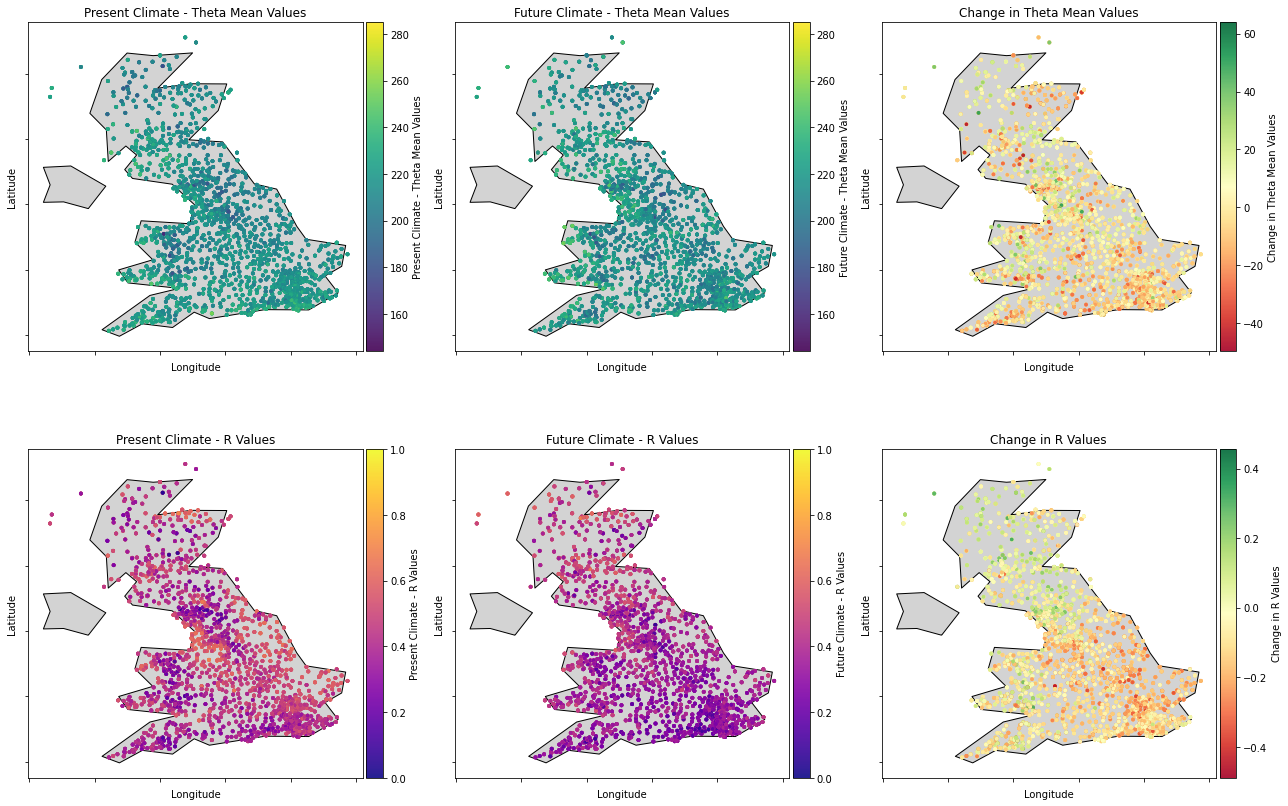

In [212]:
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for Great Britain
gb_outline = gdf[(gdf.name == "United Kingdom")]

# Create a polygon from the geometry of Great Britain for point containment check
gb_polygon = gb_outline.geometry.values[0]

# Create a figure and axes for the six subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Present Climate - Theta Mean
present_theta_data = df_changes[['Gauge_loc', 'D_mean_present']].copy()
present_theta_data['Climate'] = 'present'  # Add a Climate column for clarity
plot_values_on_map(axes[0, 0], present_theta_data, 'Present Climate - Theta Mean Values', tbo_vals, 'D_mean_present',
                   vmin = 144, vmax = 285 )

# Future Climate - Theta Mean
future_theta_data = df_changes[['Gauge_loc', 'D_mean_future']].copy()
future_theta_data['Climate'] = 'future'  # Add a Climate column for clarity
plot_values_on_map(axes[0, 1], future_theta_data, 'Future Climate - Theta Mean Values', tbo_vals, 'D_mean_future',
                                      vmin = 144, vmax = 285 )

# Change - Theta Mean
change_theta_data = df_changes[['Gauge_loc', 'D_change']].copy()
change_theta_data['Climate'] = 'change'  # Add a Climate column for clarity
plot_values_on_map(axes[0, 2], change_theta_data, 'Change in Theta Mean Values', tbo_vals, 'D_change',
                                      vmin = change_theta_data['D_change'].min(), vmax = change_theta_data['D_change'].max(),
                  cmap = 'RdYlGn')

# Present Climate - R
present_R_data = df_changes[['Gauge_loc', 'R_present']].copy()
present_R_data['Climate'] = 'present'  # Add a Climate column for clarity
plot_values_on_map(axes[1, 0], present_R_data, 'Present Climate - R Values', tbo_vals, 'R_present', 
                                      vmin =0, vmax = 1, cmap='plasma')

# Future Climate - R
future_R_data = df_changes[['Gauge_loc', 'R_future']].copy()
future_R_data['Climate'] = 'future'  # Add a Climate column for clarity
plot_values_on_map(axes[1, 1], future_R_data, 'Future Climate - R Values', tbo_vals, 'R_future',
                   vmin =0, vmax = 1, cmap='plasma')


# Change - R
change_R_data = df_changes[['Gauge_loc', 'R_change']].copy()
change_R_data['Climate'] = 'change'  # Add a Climate column for clarity
plot_values_on_map(axes[1, 2], change_R_data, 'Change in R Values', tbo_vals, 'R_change', 
                            vmin = change_R_data['R_change'].min(), vmax = change_R_data['R_change'].max(),
                  cmap = 'RdYlGn')

# Adjust layout
plt.tight_layout()


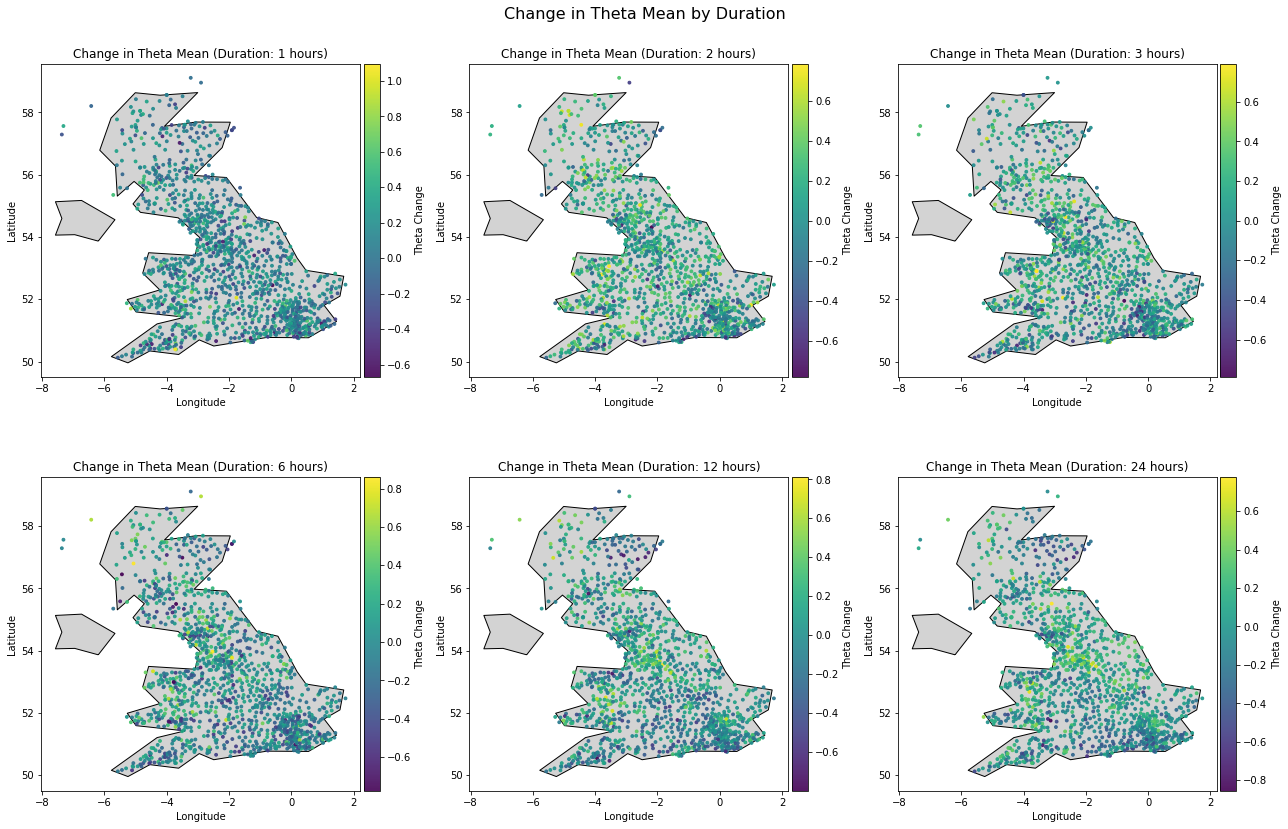

In [214]:
# Define the unique durations to iterate over
durations = df_changes['Duration_sample'].unique()
durations = ['1', '2', '3', '6', '12', '24']

### Plotting
fig_theta = plt.figure(figsize=(18, 12))
theta_axes = fig_theta.subplots(2, 3).flatten()  # Flatten the 2x4 grid into a 1D array

# Plot for each duration for theta
for i, duration in enumerate(durations):
    ax = theta_axes[i]  # Access the flattened array
    plot_change_theta_for_duration(ax, duration, df_changes, tbo_vals)

# Adjust layout for theta figure
plt.suptitle('Change in Theta Mean by Duration', fontsize=16)
# plt.subplots_adjust(top=0.9)  # Adjust title position
plt.tight_layout()
plt.show()


ValueError: 'c' argument has 1290 elements, which is inconsistent with 'x' and 'y' with size 9030.

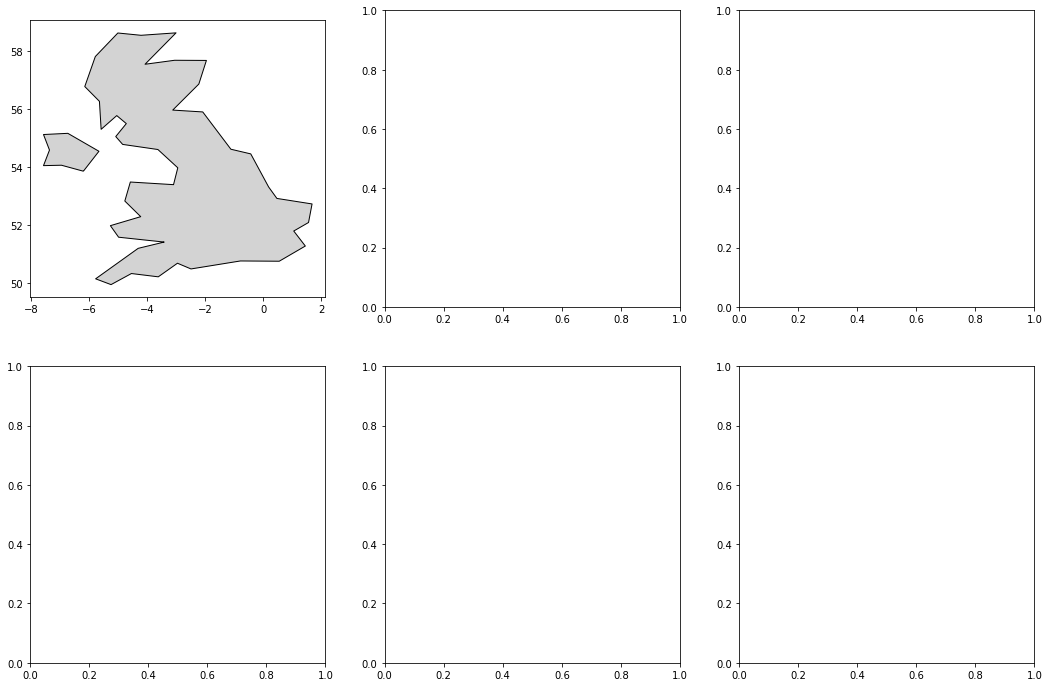

In [215]:
fig_R = plt.figure(figsize=(18, 12))
R_axes = fig_R.subplots(2, 3).flatten()  # Flatten the 2x4 grid into a 1D array

# Plot for each duration for theta
for i, duration in enumerate(durations):
    ax = R_axes[i]  # Access the flattened array
    plot_change_R_for_duration(ax, duration, df_changes, tbo_vals)

# Adjust layout for theta figure
plt.suptitle('Change in R by Duration', fontsize=16)
# plt.subplots_adjust(top=0.9)  # Adjust title position
plt.tight_layout()
plt.show()

### D50 analysis

In [13]:
# Extract 'D50_index' values from each inner dictionary
d50_values_present = []
durations_present =[]
volumes_present= []

for inner_dict in events_props_dict_present:
    if 'D50_index' in inner_dict:
        d50_values_present.append(inner_dict['D50'])
        durations_present.append(inner_dict['duration'])
        volumes_present.append(inner_dict['Volume'])

# Extract 'D50_index' values from each inner dictionary
d50_values_future = []
durations_future =[]

for inner_dict in events_props_dict_future:
    if 'D50_index' in inner_dict:
        d50_values_future.append(inner_dict['D50'])
        durations_future.append(inner_dict['duration'])


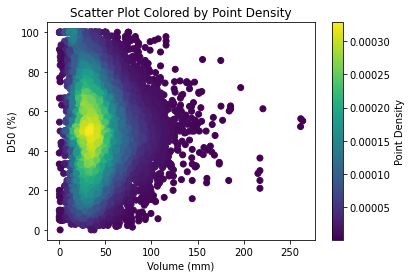

In [15]:
# Create a DataFrame from the example data
data = pd.DataFrame({
    'Duration': volumes_present,
    'D50': d50_values_present})

# Calculate point density using Gaussian KDE
kde = stats.gaussian_kde(data.T)  # Transpose to have dimensions (2, n_points)

# Calculate density for each point
density = kde(data.T)  # Evaluate the KDE at the original data points

# Create a scatter plot with colors based on density
fig,ax =plt.subplots()
scatter = ax.scatter(data['Duration'], data['D50'], c=density, cmap='viridis', edgecolor=None)

# Add labels and color bar
fig.colorbar(scatter, label='Point Density')
ax.set_xlabel('Volume (mm)')
ax.set_ylabel('D50 (%)')
ax.set_title('Scatter Plot Colored by Point Density');

In [ ]:
# Create a DataFrame from the example data
data = pd.DataFrame({
    'Duration': durations_present,
    'D50': d50_values_present})

# Calculate point density using Gaussian KDE
kde = stats.gaussian_kde(data.T)  # Transpose to have dimensions (2, n_points)

# Calculate density for each point
density = kde(data.T)  # Evaluate the KDE at the original data points

# Create a scatter plot with colors based on density
fig,ax =plt.subplots()
scatter = ax.scatter(data['Duration'], data['D50'], c=density, cmap='viridis', edgecolor=None)

# Add labels and color bar
fig.colorbar(scatter, label='Point Density')
ax.set_xlabel('Duration (hrs)')
ax.set_ylabel('D50 (%)')
ax.set_title('Scatter Plot Colored by Point Density');

In [29]:
data.sort_values(by ='D50', ascending=False)

,Duration,D50
3952,2.0,100.000000
12452,4.0,100.000000
1349,5.0,100.000000
9316,2.0,100.000000
5328,3.0,100.000000
...,...,...
1775,30.0,1.694915
1396,36.0,1.408451
13085,13.5,0.000000
5364,10.0,0.000000


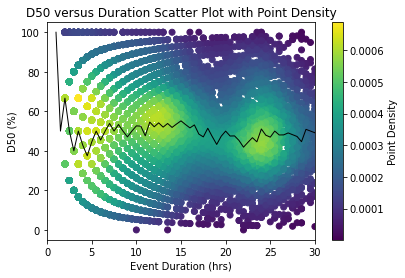

In [35]:
# Create a DataFrame from the example data
data = pd.DataFrame({
    'Duration': durations_present,  # Event durations in hours
    'D50': d50_values_present       # D50 values in percentage
})
data = data[data['Duration']>1.5]

# Calculate point density using Gaussian KDE
kde = stats.gaussian_kde(data.T)  # Transpose to have dimensions (2, n_points)

# Calculate density for each point
density = kde(data.T)  # Evaluate the KDE at the original data points

# Create a scatter plot with colors based on density
fig, ax = plt.subplots()
scatter = ax.scatter(data['Duration'], data['D50'], c=density, cmap='viridis', edgecolor=None)

# Add labels and color bar
fig.colorbar(scatter, label='Point Density')
ax.set_xlabel('Event Duration (hrs)')
ax.set_ylabel('D50 (%)')
ax.set_title('D50 versus Duration Scatter Plot with Point Density')

# Group by duration and find the maximum D50 value for each unique duration
median_d50_per_duration = data.groupby('Duration')['D50'].median().reset_index()

# Plot the maximum D50 value as a line overlaid on the scatter plot
ax.plot(max_d50_per_duration['Duration'], max_d50_per_duration['D50'], color='black', linewidth=1, linestyle='-', marker='')

# Add legend for the line
# ax.legend()
plt.xlim(0,30)
# Display the plot
plt.show()


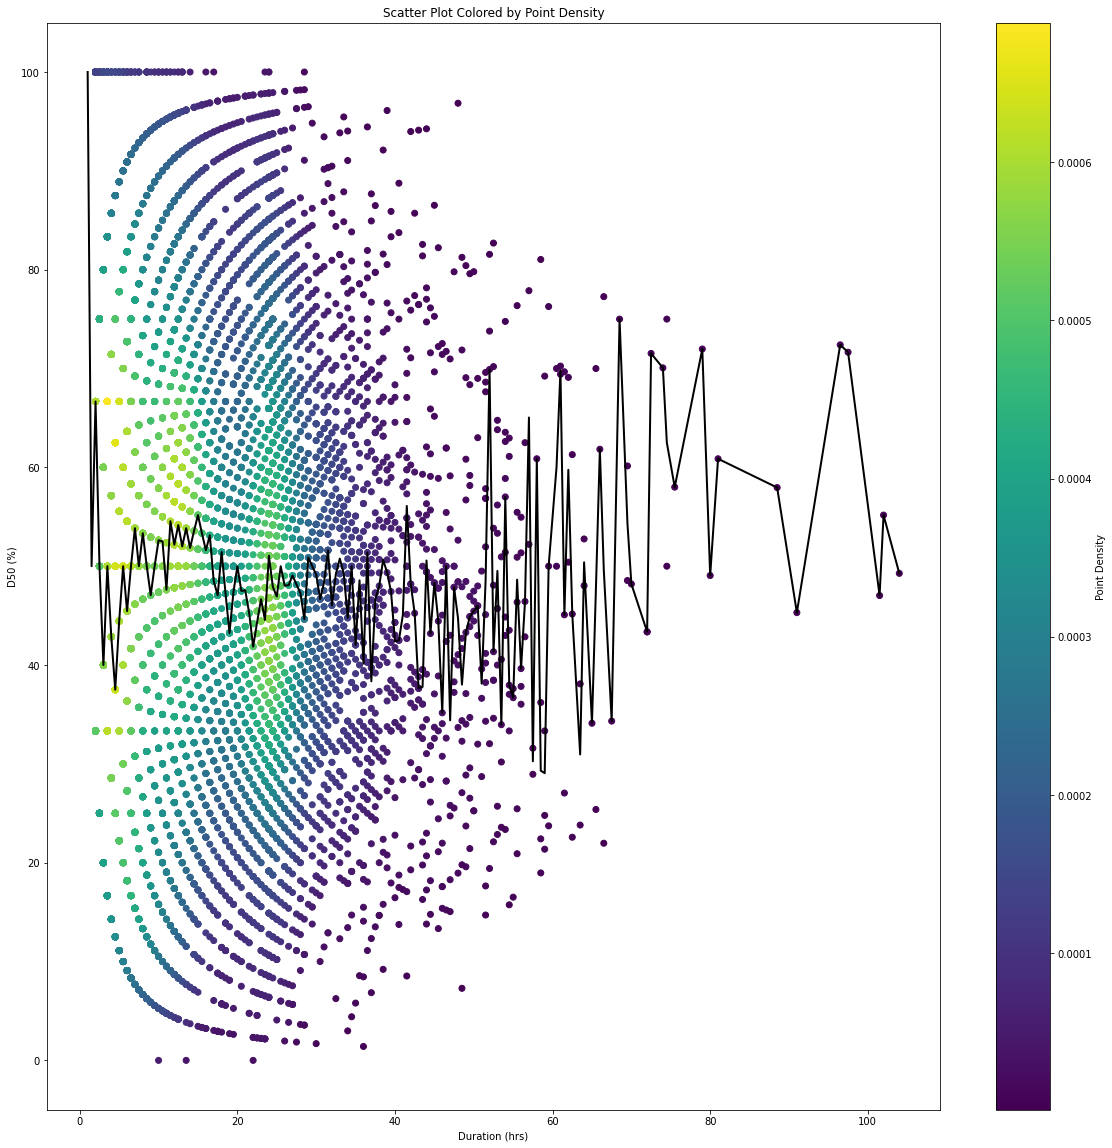

In [32]:
# Create a scatter plot with colors based on density
fig, ax = plt.subplots(figsize=(20,20))
# Create the scatter plot colored by density
scatter = ax.scatter(data['Duration'], data['D50'], c=density, cmap='viridis', edgecolor=None)

# Plot the maximum D50 values without markers
ax.plot(max_d50_per_duration['Duration'], max_d50_per_duration['D50'], color='black', linewidth=2, linestyle='-')

# Add labels and color bar
fig.colorbar(scatter, label='Point Density')
ax.set_xlabel('Duration (hrs)')
ax.set_ylabel('D50 (%)')
ax.set_title('Scatter Plot Colored by Point Density')
# Display the plot
plt.show()


In [ ]:
# durations = ['0.5', '1', '2', '3', '6', '24']

# # Create a figure with subplots for different durations
# n_categories = len(durations)
# n_variables = 2
# fig, axs = plt.subplots(n_categories, n_variables, figsize=(12, 2 * n_categories))  

# # Call the function for each variable in each duration category
# for i, duration in enumerate(durations):
#     plot_histogram_for_duration(events_props_dict_present, variable='D50', duration=duration, duration_variable="dur_for_which_this_is_amax", ax=axs[i,0], bins=10, label="Present", color='blue', alpha=0.5)
#     plot_histogram_for_duration(events_props_dict_future, variable='D50', duration=duration, duration_variable="dur_for_which_this_is_amax", ax=axs[i,0], bins=10, label="Future", color='red', alpha=0.5)
    
#     plot_histogram_for_duration(events_props_dict_present, variable='Volume', duration=duration, duration_variable="dur_for_which_this_is_amax", ax=axs[i,1], bins=25, label="Present", color='blue', alpha=0.5)
#     plot_histogram_for_duration(events_props_dict_future, variable='Volume', duration=duration, duration_variable="dur_for_which_this_is_amax", ax=axs[i,1], bins=25, label="Future", color='red', alpha=0.5)
        
#     # Set x-axis labels for the last row
#     if i == n_categories - 1:
#         axs[i,0].set_xlabel("Intensity (mm/hr)", fontsize=10)
#         axs[i,1].set_xlabel("Volume (mm)", fontsize=10)
    
#     axs[0,0].set_title("UKCP18 (Present vs Future) - d50", fontsize=12)
#     axs[0,1].set_title("UKCP18 (Present vs Future) - Volume", fontsize=12)

# # Adjust layout to prevent overlap
# plt.tight_layout()

# # Show the plot
# plt.show()
